In [1]:
import mosaik
import mosaik.util
from pv_configurations import generate_configurations, Scenarios
import simbench
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import pandapower as pp
import pandas as pd
import matplotlib
import nest_asyncio
import numpy as np
import re
import pandapower.networks as pn
import os
import sys
import geopandas
import pandapower as pp
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

from simulation_worker.SimulationWorker import find_and_lock_param_file
from create_random_network import generate_pandapower_net

# Add local-mosaik-pandapower-2.src.mosaik_components to Python path
module_path = os.path.abspath(os.path.join(os.getcwd(), 'local-mosaik-pandapower-2', 'src'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

irradiation_module_path = os.path.abspath(os.path.join(os.getcwd(), 'irradiation_module'))
if irradiation_module_path not in sys.path:
    sys.path.insert(0, irradiation_module_path)

import irradiation_model

params = find_and_lock_param_file()

if params is not None:
    net_cigre_lv, total_net_lines = generate_pandapower_net(
        CommercialRange=params['commercial_range'],
        IndustrialRange=params['industrial_range'],
        ResidencialRange=params['residential_range'],
        ForkLengthRange=params['fork_length_range'],
        LineBusesRange=params['line_buses_range'],
        LineForksRange=params['line_forks_range'],
        mv_bus_coordinates=(float(params['mv_bus_latitude']),float(params['mv_bus_longitude']))
    )
    
    






[INFO] Locked file: first_test.json


Plot the generated network

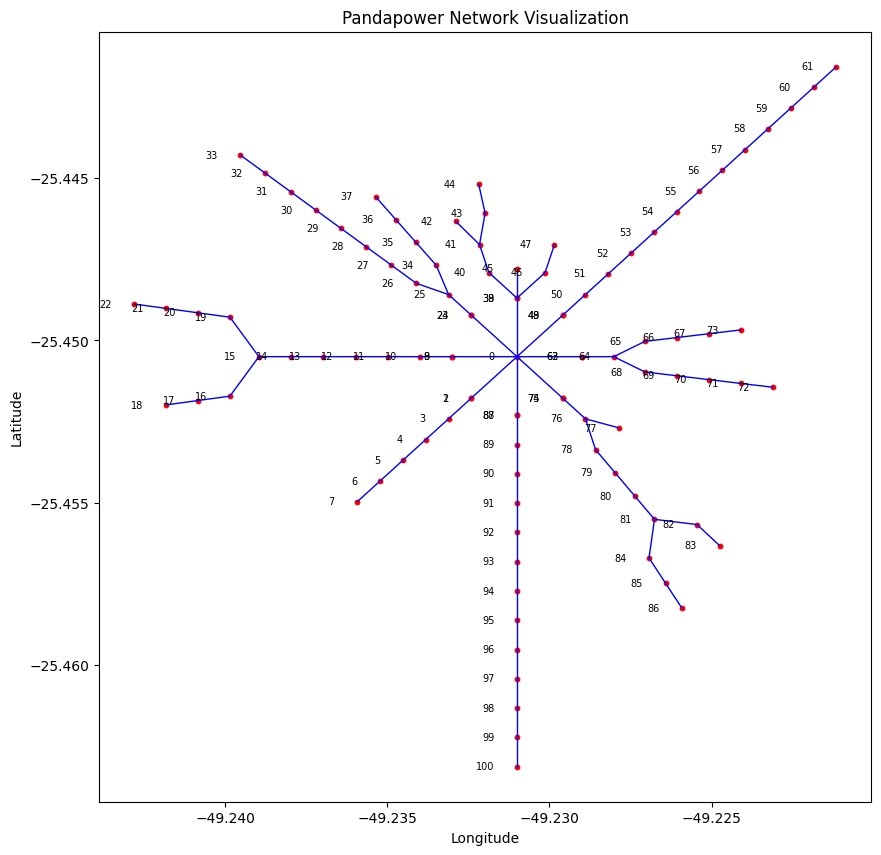

In [2]:


# Assuming you have a pandapower network 'net_cigre_lv' and line data 'total_net_lines'

# 1. Extract and convert bus geodata to shapely Points
bus_geodata = net_cigre_lv.bus["geo"]
bus_points = [Point(eval(geo)["coordinates"]) if geo else None for geo in bus_geodata]

# 2. Create a GeoSeries from the points
bus_geo_series = geopandas.GeoSeries(bus_points)

# 3. Extract line coordinates and create LineString objects
line_geometries = []
for line_data in total_net_lines:
    start_bus_index = line_data['vertices'][0]
    end_bus_index = line_data['vertices'][1]
    
    # Assuming bus_points is a list where the index corresponds to the bus index
    if start_bus_index < len(bus_points) and end_bus_index < len(bus_points):
        start_point = bus_points[start_bus_index]
        end_point = bus_points[end_bus_index]

        # Check if the points are valid (not None) before creating a LineString
        if start_point and end_point:
            line_geometries.append(LineString([start_point, end_point]))
        else:
            print(f"Warning: Skipping line between bus {start_bus_index} and {end_bus_index} due to missing coordinates.")
    else:
        print(f"Warning: Skipping line between bus {start_bus_index} and {end_bus_index} due to out-of-bounds bus index.")

# 4. Create a GeoDataFrame for the lines
line_geo_df = geopandas.GeoDataFrame({'geometry': line_geometries})

# 5. Plot the network
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
# Plot lines
line_geo_df.plot(ax=ax, color='blue', linewidth=1)

# Plot buses as points
bus_geo_series.plot(ax=ax, color='red', markersize=10)
# Annotate each bus with its node number (index), placing text to the left of the point
for idx, point in enumerate(bus_geo_series):
    if point is not None:
        ax.text(point.x - 0.0007, point.y, str(idx), fontsize=7, color='black', ha='right', va='center')

plt.title("Pandapower Network Visualization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Plot Network Topology

NameError: name 'net' is not defined

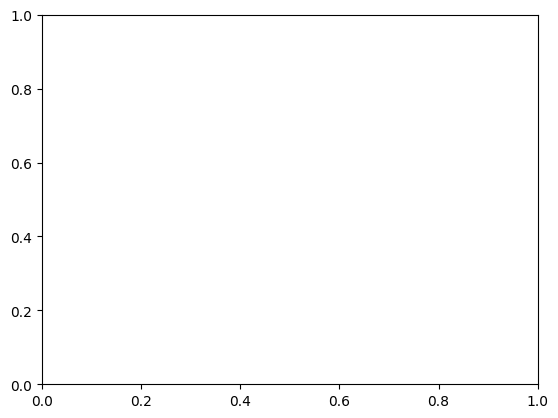

In [4]:
fig, ax = plt.subplots()
plot.simple_plot(net, ax=ax, show_plot=False)

# --- Annotate LOADS ---
for load in loads:
    load_data = net.load.iloc[load.extra_info['index']]
    x, y = net.bus_geodata.loc[load_data['bus'], ['x', 'y']]     
    ax.text(x, y, f'Load: {load_data['name']}\nEID: {load.eid}', fontsize=5, color='blue')

# --- Annotate LINES ---
for line in lines:
    line_data = net.line.iloc[line.extra_info['index']]
    fb, tb = line_data['from_bus'], line_data['to_bus']
    x1, y1 = net.bus_geodata.loc[fb, ['x', 'y']]
    x2, y2 = net.bus_geodata.loc[tb, ['x', 'y']]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    name = line_data['name']
    ax.text(xm, ym, f'Line: {line_data['name']}\nEID: {line.eid}', fontsize=5, color='green', ha='center')

# --- Annotate TRANSFORMERS ---
for eid, trafo in net.trafo.iterrows():
    hb, lb = trafo.hv_bus, trafo.lv_bus
    x1, y1 = net.bus_geodata.loc[hb, ['x', 'y']]
    x2, y2 = net.bus_geodata.loc[lb, ['x', 'y']]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    name = trafo['name']
    ax.text(xm, ym, f'Trafo: {name}\nEID: {eid}', fontsize=5, color='orange', ha='center')

# --- Annotate GENERATORS ---
for gen in generators:
    gen_data = net.sgen.iloc[gen.extra_info['index']]
    x, y = net.bus_geodata.loc[gen_data['bus'], ['x', 'y']]    
    ax.text(x + 5, y + 5, f'Gen: {gen_data['name']}\nEID: {gen.eid}', fontsize=5, color='red')

# --- Annotate SHUNTS ---
for eid, shunt in net.shunt.iterrows():
    bus = shunt.bus
    x, y = net.bus_geodata.loc[bus, ['x', 'y']]
    name = shunt['name'] 
    ax.text(x - 5, y - 5, f'Shunt: {name}\nEID: {eid}', fontsize=5, color='purple')

# --- Annotate STORAGE ---
for eid, storage in net.storage.iterrows():
    bus = storage.bus
    x, y = net.bus_geodata.loc[bus, ['x', 'y']]
    name = storage['name'] 
    ax.text(x + 5, y - 5, f'Storage: {name}\nEID: {eid}', fontsize=5, color='brown')

plt.tight_layout()
plt.savefig("topology.pdf")
plt.show()


Run the simulation

In [ ]:
 # Run simulation
    
world.run(until=END)

2025-05-22 19:23:01.313 | INFO     | mosaik.async_scenario:run:789 - Starting simulation.
100%|██████████| 259200/259200 [00:12<00:00, 19952.75steps/s]
2025-05-22 19:23:14.312 | INFO     | mosaik.async_scenario:run:845 - Simulation finished successfully.


Check solar irradiation

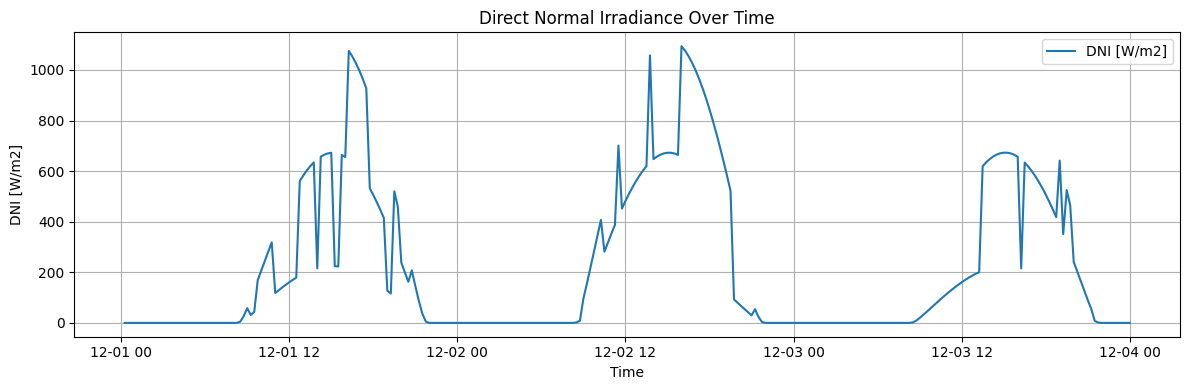

In [ ]:
# Plot the solar irradiation as a function of time
df = pd.read_csv('results.csv', parse_dates=['date'], index_col='date')

dni_col = 'SolarIrradiation-0.SolarIrradiation_0-DNI[W/m2]'
if dni_col in df.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[dni_col], label='DNI [W/m2]')
    plt.xlabel('Time')
    plt.ylabel('DNI [W/m2]')
    plt.title('Direct Normal Irradiance Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Column '{dni_col}' not found in results.csv")

Tensão nas barras

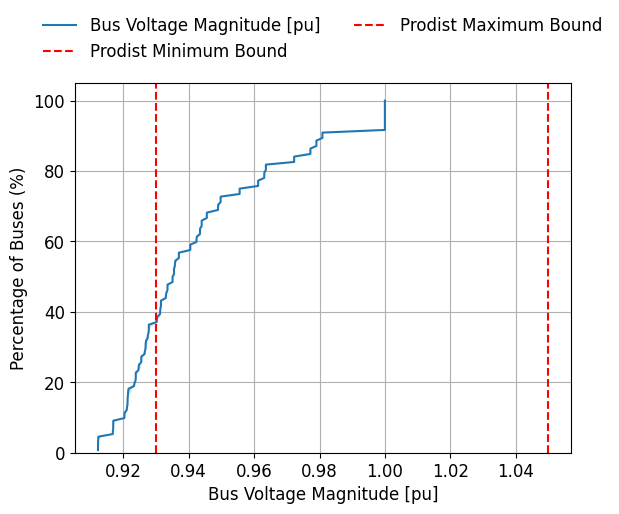

In [ ]:
# Função para plotar CDF com sombra
def plot_cdf_with_shadow(data_mean, data_hi, data_lo, label):
    sorted_data_mean = np.sort(data_mean)
    #cdf = 100*np.arange(len(sorted_data_mean)) / float(len(sorted_data_mean))
    cdf = np.arange(1, len(sorted_data_mean) + 1) / len(sorted_data_mean) * 100

    
    sorted_data_hi = np.sort(data_hi)
    sorted_data_lo = np.sort(data_lo)
    
    plt.plot(sorted_data_mean, cdf, label=label)
    plt.fill_betweenx(cdf, sorted_data_lo, sorted_data_hi, alpha=0.2)


# Read the CSV file
df = pd.read_csv('results.csv', parse_dates=['date'], index_col='date')

# Filter columns that match the Bus voltage magnitude pattern
voltage_columns = [col for col in df.columns if re.search(r"Bus-\d+-Vm_[a|b|c]\[pu\]$", col)]
voltage_df = df[voltage_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': voltage_df.mean(),
    'Max': voltage_df.max(),
    'Min': voltage_df.min()
})


# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Bus Voltage Magnitude [pu]')

plt.xlabel('Bus Voltage Magnitude [pu]', fontsize=12)
plt.ylabel('Percentage of Buses (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Perda de potência ativa nas barras

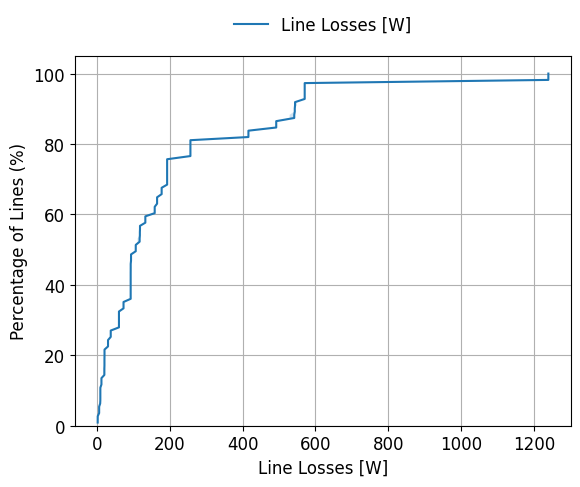

In [ ]:

# Filter columns that match the Bus voltage magnitude pattern
loss_columns = [col for col in df.columns if re.search(r"Line-\d+-Pl_[a|b|c]\[MW\]$", col)]
loss_df = df[loss_columns]*1e6

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': loss_df.mean(),
    'Max': loss_df.max(),
    'Min': loss_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Losses [W]')

plt.xlabel('Line Losses [W]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Corrente de Neutro

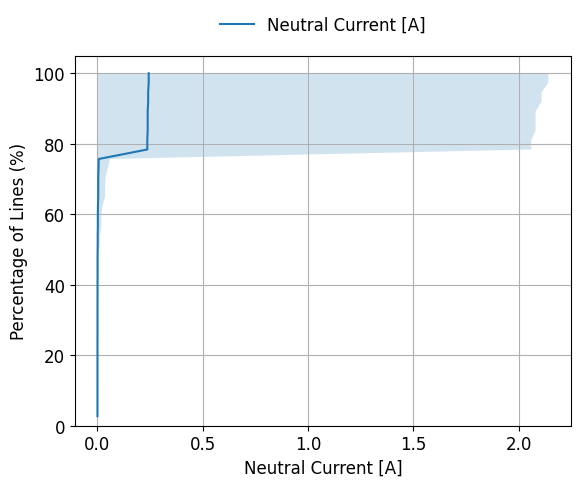

In [ ]:
# Filter columns that match the Bus voltage magnitude pattern
neutral_current_columns = [col for col in df.columns if re.search(r"Line-\d+-I_n_from\[kA\]$", col)]
neutral_current_df = df[neutral_current_columns]*1e3

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': neutral_current_df.mean(),
    'Max': neutral_current_df.max(),
    'Min': neutral_current_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Neutral Current [A]')

plt.xlabel('Neutral Current [A]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Line Loading

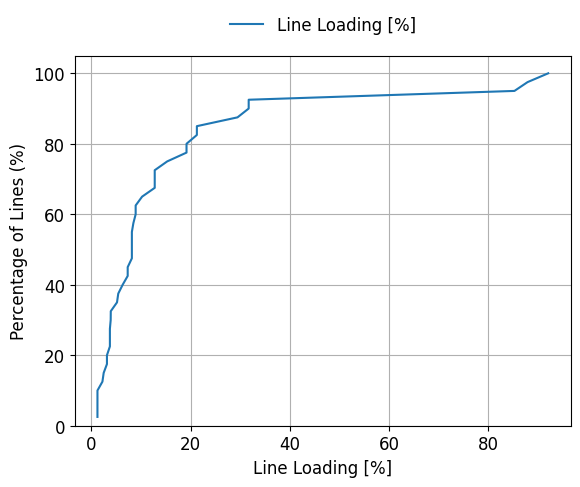

In [ ]:
# Filter columns that match the Bus voltage magnitude pattern
line_loading_columns = [col for col in df.columns if re.search(r"Loading\[%\]$", col)]
line_loading_df = df[line_loading_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': line_loading_df.mean(),
    'Max': line_loading_df.max(),
    'Min': line_loading_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Loading [%]')

plt.xlabel('Line Loading [%]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Desbalanceamento de Barramentos

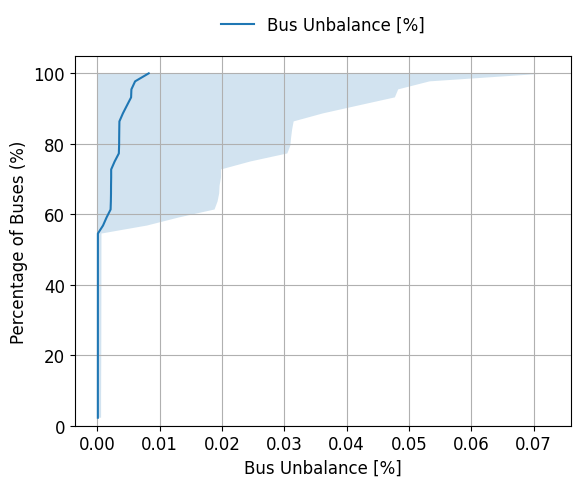

In [ ]:

# Filter columns that match the Bus voltage magnitude pattern
unbalance_columns = [col for col in df.columns if re.search(r"Bus-\d+-Unbalance\[%\]$", col)]
unbalance_df = df[unbalance_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': unbalance_df.mean(),
    'Max': unbalance_df.max(),
    'Min': unbalance_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Bus Unbalance [%]')

plt.xlabel('Bus Unbalance [%]', fontsize=12)
plt.ylabel('Percentage of Buses (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Total Power

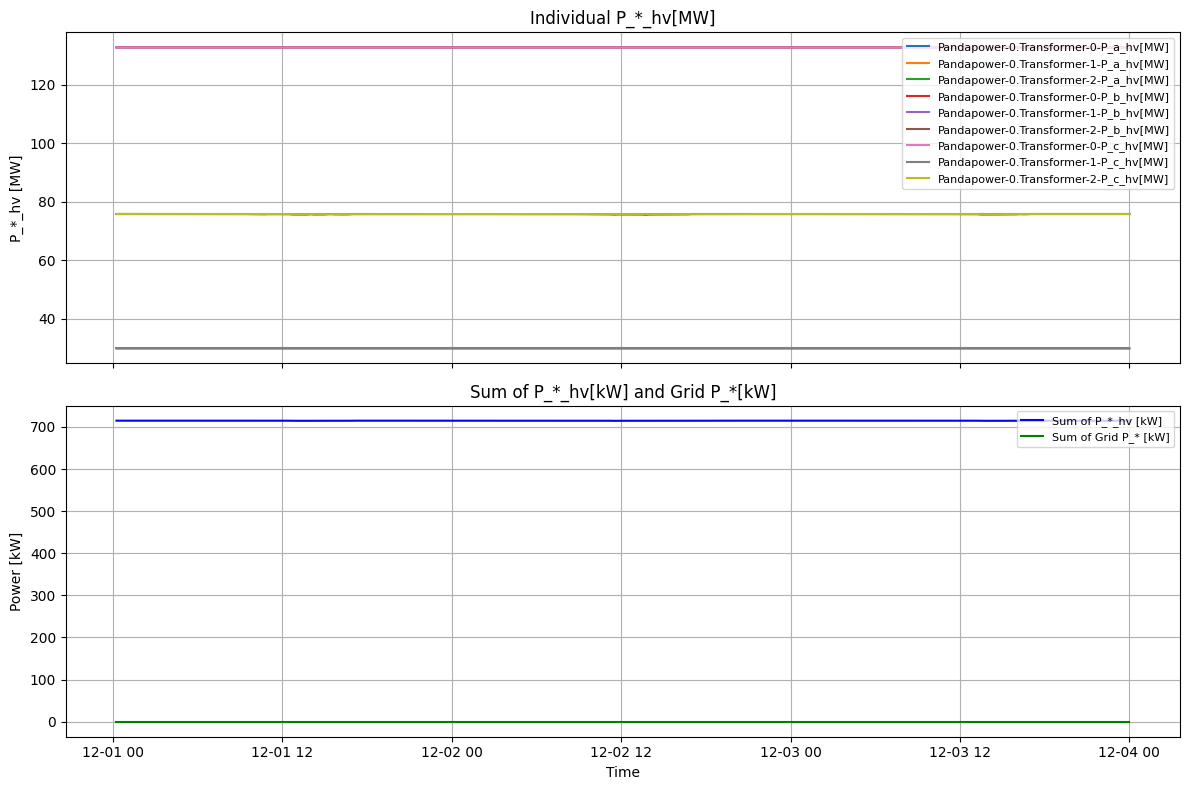

In [ ]:
# Filter columns for P_*_hv[MW] and P_*[MW]
p_hv_columns = [col for col in df.columns if re.search(r"Pandapower-0.Transformer-\d+-P_[a|b|c]_lv\[MW\]$", col)]
p_grid_columns = [col for col in df.columns if re.search(r"Pandapower-0.Transformer-\d+-P_[a|b|c]_lv\[MW\]$", col)]

# DataFrames for the filtered columns
p_hv_df = df[p_hv_columns]
p_grid_df = df[p_grid_columns]

# Calculate the sum of P_*_hv[MW] and P_*[MW]
p_hv_sum = p_hv_df.sum(axis=1)
p_grid_sum = p_grid_df.sum(axis=1)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# First subplot: Plot every P_*_hv[MW]
for col in p_hv_columns:
    axes[0].plot(df.index, df[col]*1000, label=col)
axes[0].set_ylabel('P_*_hv [MW]')
axes[0].set_title('Individual P_*_hv[MW]')
axes[0].legend(loc='upper right', fontsize=8)
axes[0].grid(True)

# Second subplot: Plot the sum of P_*_hv[MW] and grid P_*[MW]
axes[1].plot(df.index, p_hv_sum*1000, label='Sum of P_*_hv [kW]', color='blue')
axes[1].plot(df.index, p_grid_sum*1000, label='Sum of Grid P_* [kW]', color='green')
axes[1].set_ylabel('Power [kW]')
axes[1].set_title('Sum of P_*_hv[kW] and Grid P_*[kW]')
axes[1].legend(loc='upper right', fontsize=8)
axes[1].grid(True)

# Finalize plot
plt.xlabel('Time')
plt.tight_layout()
plt.show()